# Run All

### Set up Kaggle API

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download "gpreda/covid-world-vaccination-progress"
!unzip covid-world-vaccination-progress.zip

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes
covid-world-vaccination-progress.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  covid-world-vaccination-progress.zip
replace country_vaccinations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: country_vaccinations.csv  


### Import Data and libraries ###

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
from sklearn.linear_model import LinearRegression
!pip install plotly==4.14.3
import plotly
import plotly.express as px
import seaborn as sns
from fbprophet import Prophet
from datetime import datetime, timedelta
import math

In [ ]:
big_df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
big_df['date'] = pd.to_datetime(big_df['date'])
big_df['country'] = big_df['location']
big_df.shape

(79678, 60)

In [ ]:
df = pd.read_csv('country_vaccinations.csv')
df['date'] = pd.to_datetime(df['date'])
len(df.country.unique())
cols = df.columns
countries = list(df.country.unique())
print(countries)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Bermuda', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei', 'Bulgaria', 'Cambodia', 'Canada', 'Cape Verde', 'Cayman Islands', 'Chile', 'China', 'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'Equatorial Guinea', 'Estonia', 'Faeroe Islands', 'Falkland Islands', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guatemala', 'Guernsey', 'Guinea', 'Guyana', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Laos', 'Latvia', 'Lebanon'

In [ ]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'New York State': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Bureau of Prisons':0,
    'Dept of Defense':1,
    'Federated States of Micronesia':2,
    'Indian Health Svc':3,
    'Long Term Care':4,
    'Marshall Islands':5,
    'Republic of Palau':6,
    'United States':7,
    'Veterans Health':8
}

### Analysis


#### Exploratory Analysis

In [ ]:
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...


In [ ]:
len(df.country.unique())

166

In [ ]:
count = df.groupby('country').count()
count['Recorded days of vaccine'] = count['iso_code']
count['country'] = count['iso_code']
count = count.drop(columns=cols)
count.head()

,Recorded days of vaccine
country,
Afghanistan,23
Albania,83
Algeria,22
Andorra,54
Angola,29


In [ ]:
df.describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,5.772000e+03,5.167000e+03,3.608000e+03,4.816000e+03,9.393000e+03,5772.000000,5167.000000,3608.000000,9393.000000
mean,3.223423e+06,2.406510e+06,1.076638e+06,1.115403e+05,6.705204e+04,11.486305,8.540521,4.171486,2835.473651
std,1.198154e+07,8.122148e+06,4.359236e+06,4.026947e+05,2.645468e+05,19.689933,13.053528,8.765672,4994.852975
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,4.589425e+04,4.177000e+04,1.999125e+04,2.972250e+03,9.730000e+02,0.870000,0.860000,0.440000,361.000000
50%,3.091255e+05,2.723230e+05,1.251490e+05,1.453950e+04,5.979000e+03,4.350000,3.520000,1.595000,1398.000000
75%,1.522704e+06,1.157205e+06,5.511082e+05,6.057000e+04,2.824500e+04,13.192500,9.950000,3.910000,3474.000000
max,1.616884e+08,1.042135e+08,5.985815e+07,7.185000e+06,5.190143e+06,180.780000,95.850000,84.930000,118759.000000


In [ ]:
df.daily_vaccinations.sum()

629819853.0

#### Cases vs Vaccine Numbers

too many


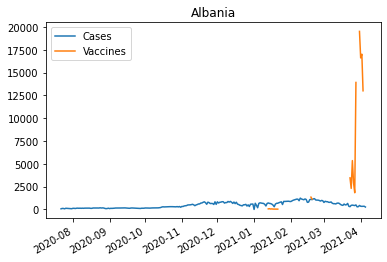

In Albania, before the vaccine, 341.53 cases occured daily on average.
After the vaccine, 741.42 cases occured daily on average.

too many
too many
too many
too many
too many


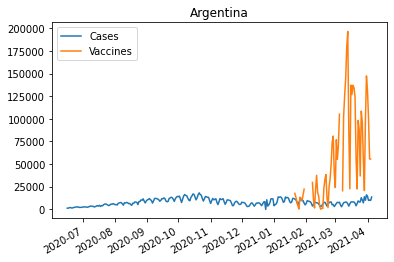

In Argentina, before the vaccine, 7947.59 cases occured daily on average.
After the vaccine, 8333.12 cases occured daily on average.



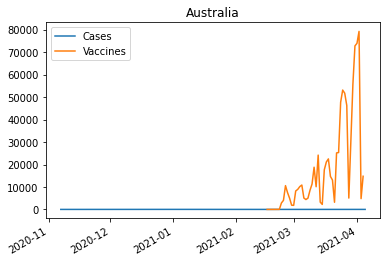

In Australia, before the vaccine, 12.48 cases occured daily on average.
After the vaccine, 9.3 cases occured daily on average.



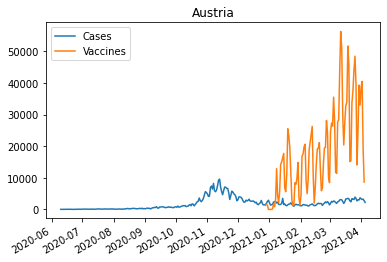

In Austria, before the vaccine, 1667.53 cases occured daily on average.
After the vaccine, 2104.88 cases occured daily on average.

too many
too many


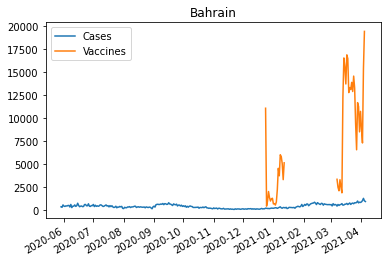

In Bahrain, before the vaccine, 387.41 cases occured daily on average.
After the vaccine, 568.82 cases occured daily on average.

too many


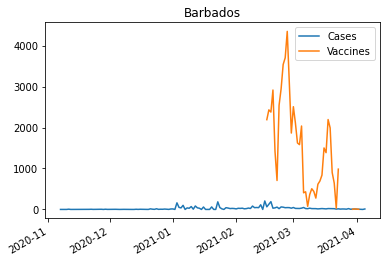

In Barbados, before the vaccine, 18.19 cases occured daily on average.
After the vaccine, 32.36 cases occured daily on average.

too many


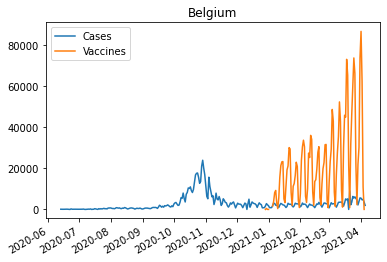

In Belgium, before the vaccine, 2924.54 cases occured daily on average.
After the vaccine, 2667.55 cases occured daily on average.



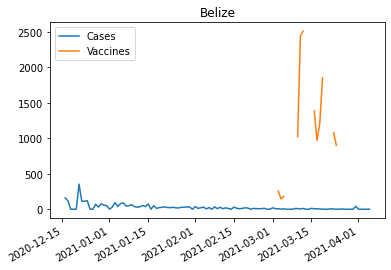

In Belize, before the vaccine, 37.59 cases occured daily on average.
After the vaccine, 4.41 cases occured daily on average.

too many


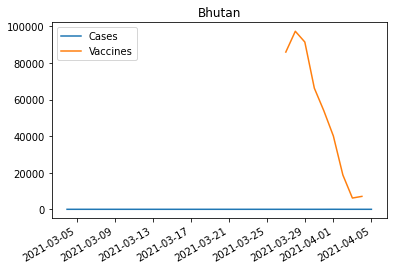

In Bhutan, before the vaccine, 0.14 cases occured daily on average.
After the vaccine, 1.91 cases occured daily on average.



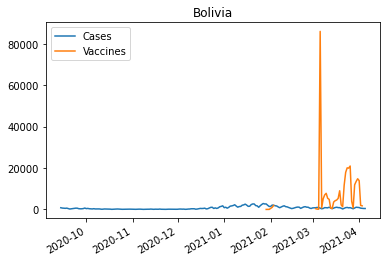

In Bolivia, before the vaccine, 597.67 cases occured daily on average.
After the vaccine, 989.97 cases occured daily on average.



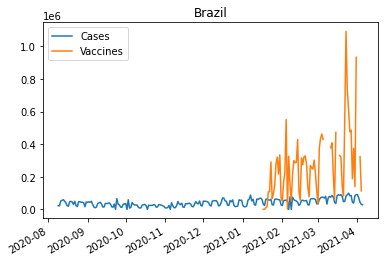

In Brazil, before the vaccine, 33631.75 cases occured daily on average.
After the vaccine, 57751.36 cases occured daily on average.



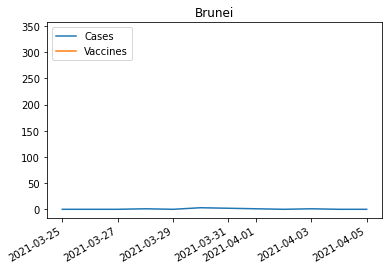

In Brunei, before the vaccine, 0.88 cases occured daily on average.
After the vaccine, 0.25 cases occured daily on average.



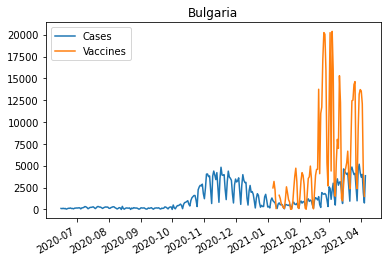

In Bulgaria, before the vaccine, 993.43 cases occured daily on average.
After the vaccine, 1620.47 cases occured daily on average.



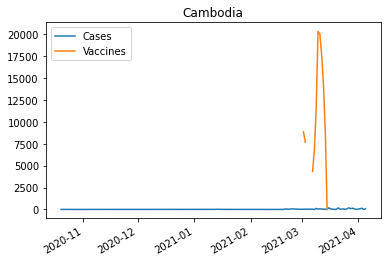

In Cambodia, before the vaccine, 1.71 cases occured daily on average.
After the vaccine, 40.64 cases occured daily on average.



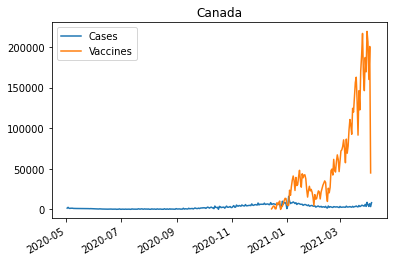

In Canada, before the vaccine, 1805.75 cases occured daily on average.
After the vaccine, 4891.04 cases occured daily on average.

too many
too many


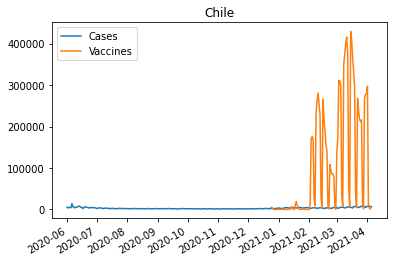

In Chile, before the vaccine, 2268.76 cases occured daily on average.
After the vaccine, 4288.33 cases occured daily on average.

too many


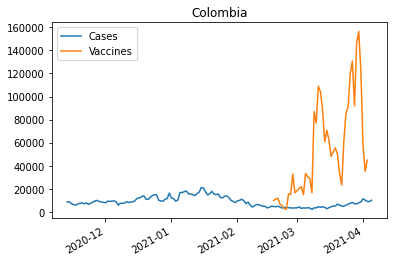

In Colombia, before the vaccine, 10714.44 cases occured daily on average.
After the vaccine, 5287.73 cases occured daily on average.

too many


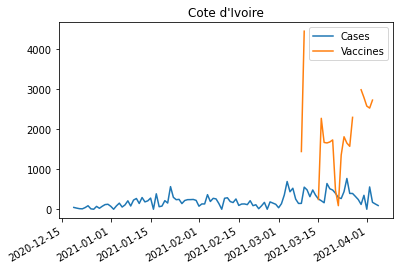

In Cote d'Ivoire, before the vaccine, 151.51 cases occured daily on average.
After the vaccine, 335.75 cases occured daily on average.

too many
too many


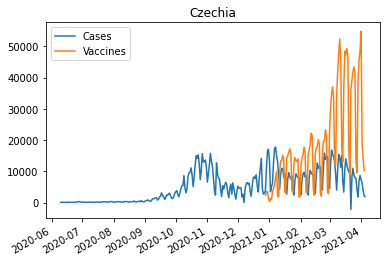

In Czechia, before the vaccine, 3289.09 cases occured daily on average.
After the vaccine, 8862.51 cases occured daily on average.



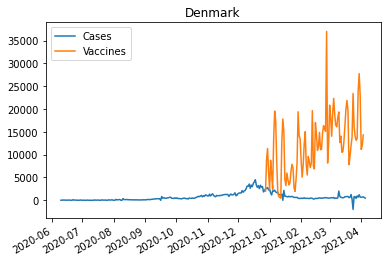

In Denmark, before the vaccine, 697.82 cases occured daily on average.
After the vaccine, 827.25 cases occured daily on average.

too many


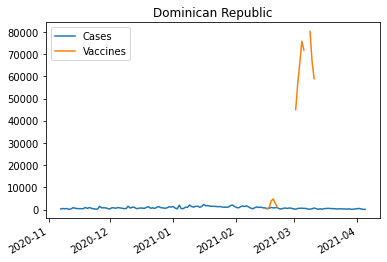

In Dominican Republic, before the vaccine, 1004.68 cases occured daily on average.
After the vaccine, 493.34 cases occured daily on average.

too many
too many
too many
too many
too many


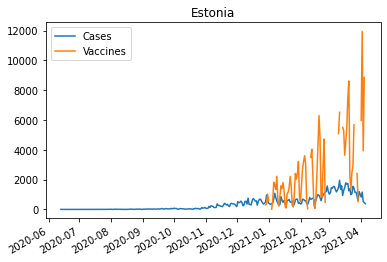

In Estonia, before the vaccine, 118.29 cases occured daily on average.
After the vaccine, 852.41 cases occured daily on average.

too many
too many


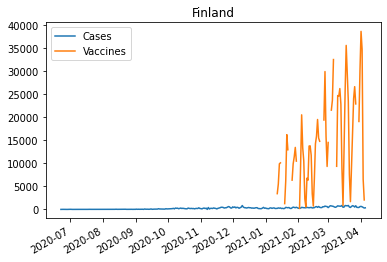

In Finland, before the vaccine, 149.56 cases occured daily on average.
After the vaccine, 457.07 cases occured daily on average.



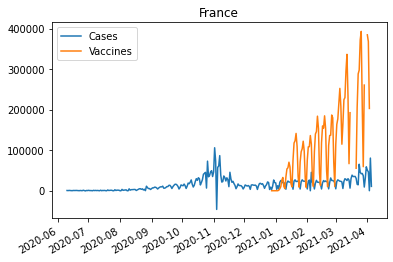

In France, before the vaccine, 12067.49 cases occured daily on average.
After the vaccine, 22862.83 cases occured daily on average.

too many
too many
too many


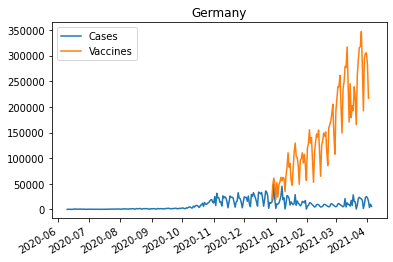

In Germany, before the vaccine, 7298.67 cases occured daily on average.
After the vaccine, 12560.69 cases occured daily on average.

too many
too many


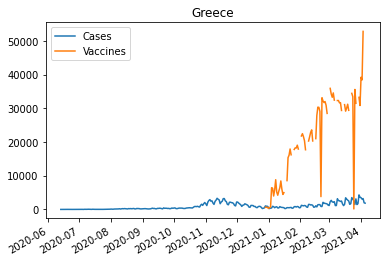

In Greece, before the vaccine, 668.42 cases occured daily on average.
After the vaccine, 1432.54 cases occured daily on average.

too many
too many


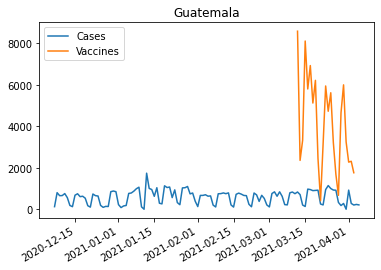

In Guatemala, before the vaccine, 590.17 cases occured daily on average.
After the vaccine, 572.9 cases occured daily on average.

too many
too many
too many
too many
too many


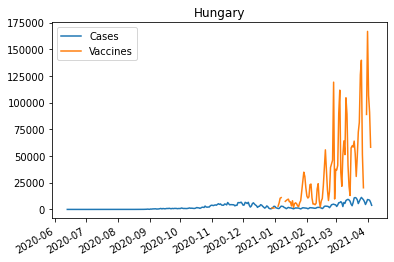

In Hungary, before the vaccine, 1575.79 cases occured daily on average.
After the vaccine, 3775.69 cases occured daily on average.

too many


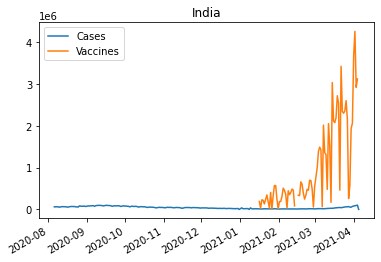

In India, before the vaccine, 52858.93 cases occured daily on average.
After the vaccine, 25449.19 cases occured daily on average.



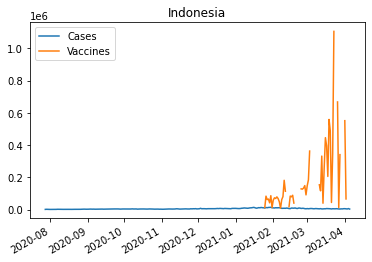

In Indonesia, before the vaccine, 4383.42 cases occured daily on average.
After the vaccine, 8348.2 cases occured daily on average.

too many
too many


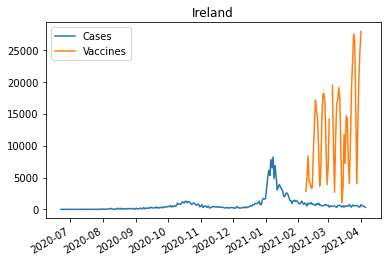

In Ireland, before the vaccine, 337.39 cases occured daily on average.
After the vaccine, 1544.89 cases occured daily on average.

too many


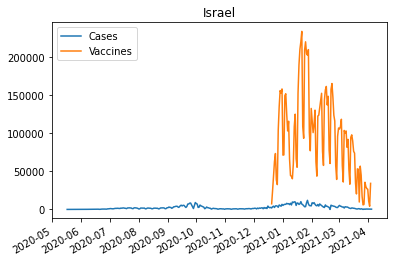

In Israel, before the vaccine, 1637.15 cases occured daily on average.
After the vaccine, 4300.47 cases occured daily on average.



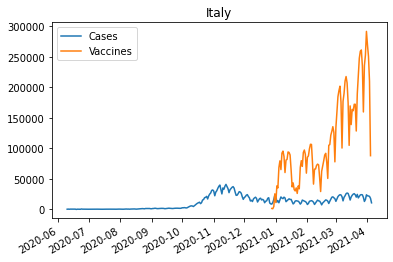

In Italy, before the vaccine, 9015.99 cases occured daily on average.
After the vaccine, 16401.85 cases occured daily on average.

too many


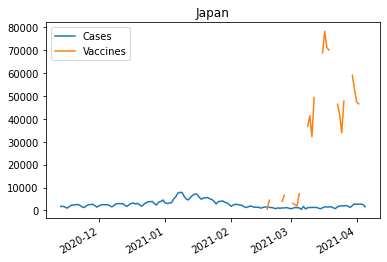

In Japan, before the vaccine, 3174.79 cases occured daily on average.
After the vaccine, 1424.1 cases occured daily on average.

too many
too many
too many
too many
too many
too many
too many


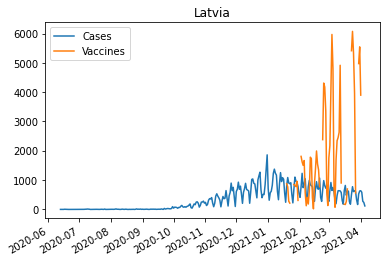

In Latvia, before the vaccine, 177.95 cases occured daily on average.
After the vaccine, 685.8 cases occured daily on average.



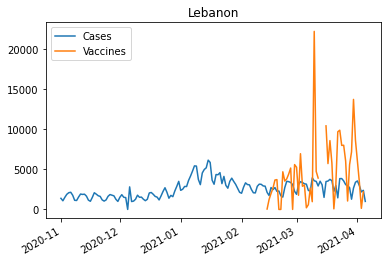

In Lebanon, before the vaccine, 2431.39 cases occured daily on average.
After the vaccine, 2815.56 cases occured daily on average.

too many


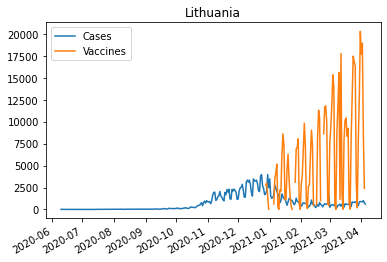

In Lithuania, before the vaccine, 640.96 cases occured daily on average.
After the vaccine, 902.98 cases occured daily on average.



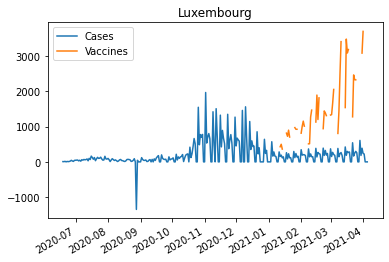

In Luxembourg, before the vaccine, 216.48 cases occured daily on average.
After the vaccine, 165.12 cases occured daily on average.

too many


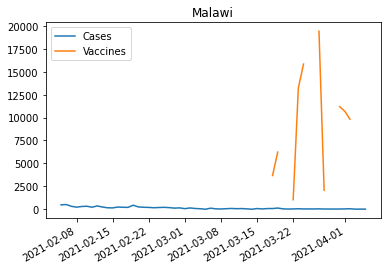

In Malawi, before the vaccine, 175.25 cases occured daily on average.
After the vaccine, 38.95 cases occured daily on average.



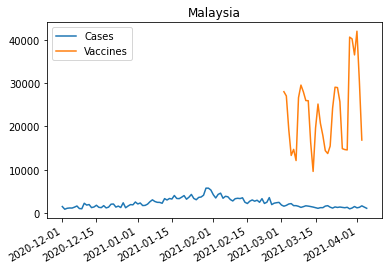

In Malaysia, before the vaccine, 2619.81 cases occured daily on average.
After the vaccine, 1577.81 cases occured daily on average.



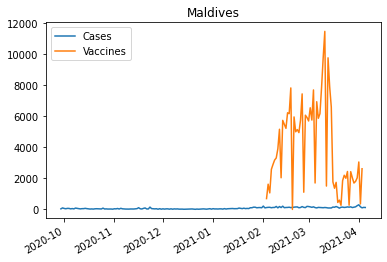

In Maldives, before the vaccine, 46.82 cases occured daily on average.
After the vaccine, 140.51 cases occured daily on average.

too many


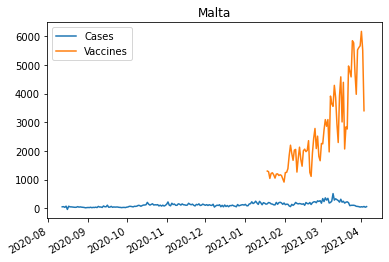

In Malta, before the vaccine, 90.54 cases occured daily on average.
After the vaccine, 175.09 cases occured daily on average.

too many
too many


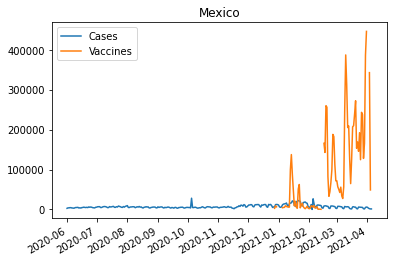

In Mexico, before the vaccine, 6113.67 cases occured daily on average.
After the vaccine, 8753.65 cases occured daily on average.



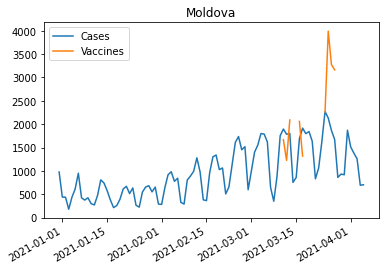

In Moldova, before the vaccine, 739.94 cases occured daily on average.
After the vaccine, 1393.53 cases occured daily on average.

too many


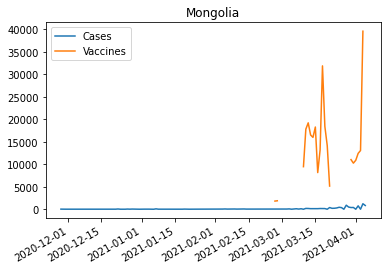

In Mongolia, before the vaccine, 22.48 cases occured daily on average.
After the vaccine, 208.33 cases occured daily on average.



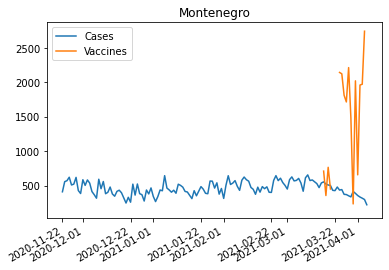

In Montenegro, before the vaccine, 449.54 cases occured daily on average.
After the vaccine, 480.62 cases occured daily on average.

too many


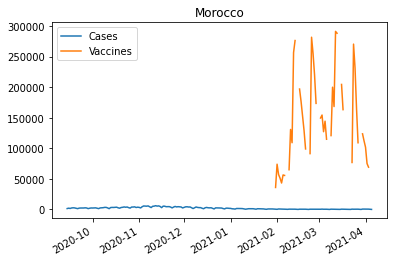

In Morocco, before the vaccine, 2806.6 cases occured daily on average.
After the vaccine, 440.38 cases occured daily on average.

too many
too many
too many
too many
too many
too many
too many
too many
too many
too many


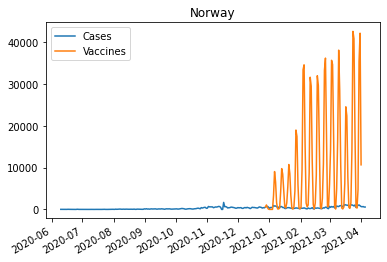

In Norway, before the vaccine, 190.51 cases occured daily on average.
After the vaccine, 525.71 cases occured daily on average.



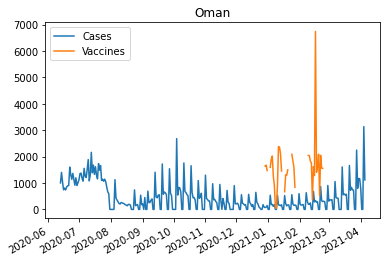

In Oman, before the vaccine, 542.43 cases occured daily on average.
After the vaccine, 361.64 cases occured daily on average.

too many


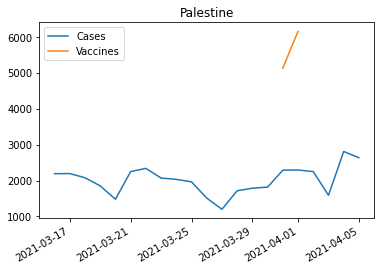

In Palestine, before the vaccine, 1903.29 cases occured daily on average.
After the vaccine, 2239.14 cases occured daily on average.



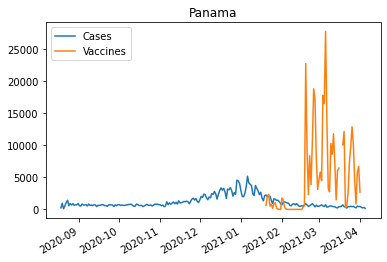

In Panama, before the vaccine, 1407.91 cases occured daily on average.
After the vaccine, 742.79 cases occured daily on average.



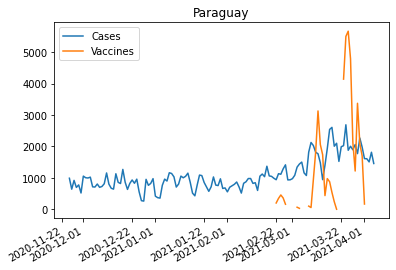

In Paraguay, before the vaccine, 827.73 cases occured daily on average.
After the vaccine, 1634.82 cases occured daily on average.



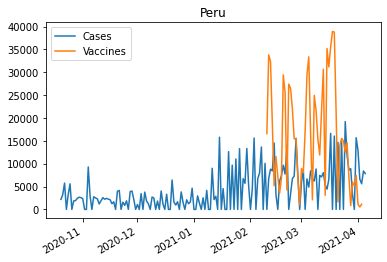

In Peru, before the vaccine, 2839.49 cases occured daily on average.
After the vaccine, 7205.55 cases occured daily on average.

too many


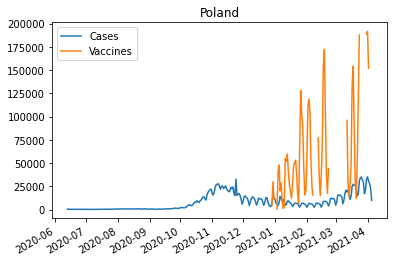

In Poland, before the vaccine, 6208.19 cases occured daily on average.
After the vaccine, 12026.91 cases occured daily on average.

too many
too many


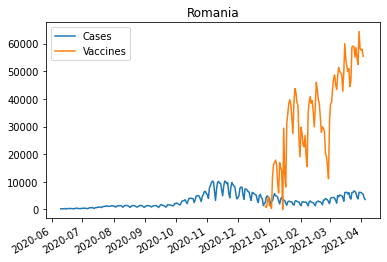

In Romania, before the vaccine, 2965.05 cases occured daily on average.
After the vaccine, 3642.26 cases occured daily on average.



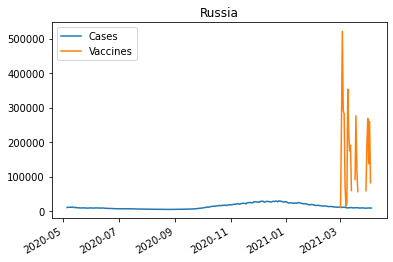

In Russia, before the vaccine, 11211.31 cases occured daily on average.
After the vaccine, 16799.11 cases occured daily on average.



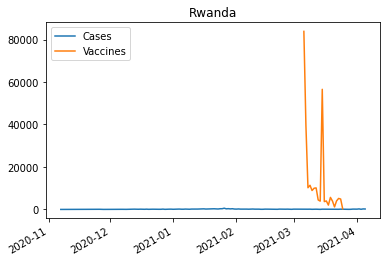

In Rwanda, before the vaccine, 121.35 cases occured daily on average.
After the vaccine, 106.82 cases occured daily on average.

too many
too many
too many
too many


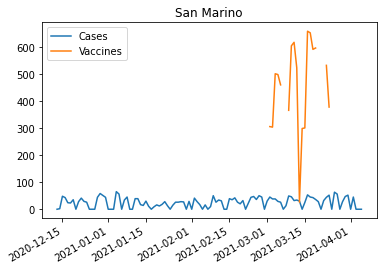

In San Marino, before the vaccine, 22.88 cases occured daily on average.
After the vaccine, 29.05 cases occured daily on average.

too many


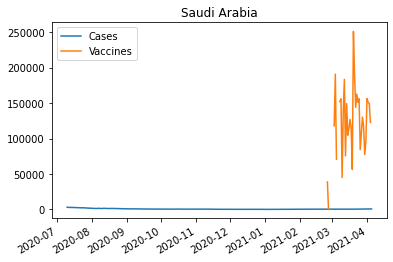

In Saudi Arabia, before the vaccine, 777.4 cases occured daily on average.
After the vaccine, 334.64 cases occured daily on average.

too many


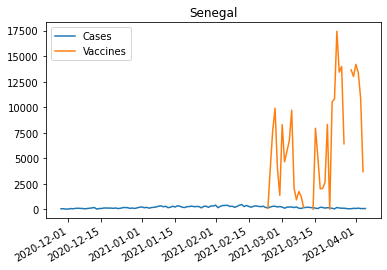

In Senegal, before the vaccine, 197.05 cases occured daily on average.
After the vaccine, 143.4 cases occured daily on average.



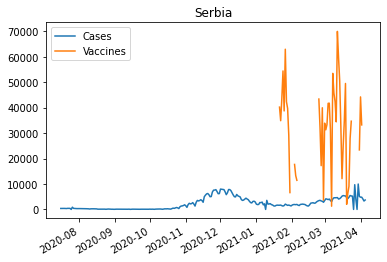

In Serbia, before the vaccine, 1900.98 cases occured daily on average.
After the vaccine, 3039.41 cases occured daily on average.



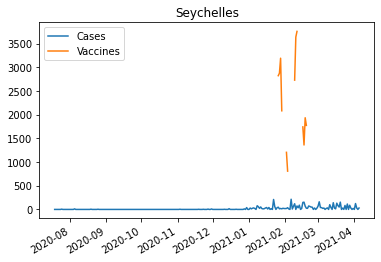

In Seychelles, before the vaccine, 1.97 cases occured daily on average.
After the vaccine, 44.47 cases occured daily on average.

too many
too many


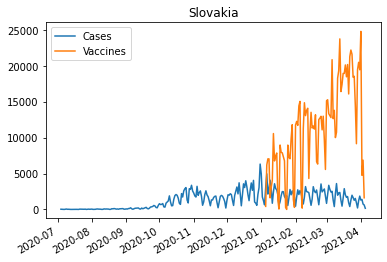

In Slovakia, before the vaccine, 1009.47 cases occured daily on average.
After the vaccine, 1934.1 cases occured daily on average.



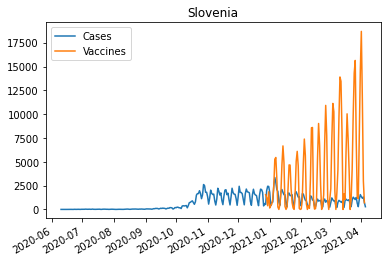

In Slovenia, before the vaccine, 563.49 cases occured daily on average.
After the vaccine, 1062.41 cases occured daily on average.



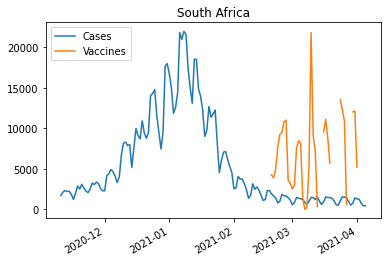

In South Africa, before the vaccine, 7697.8 cases occured daily on average.
After the vaccine, 1214.43 cases occured daily on average.



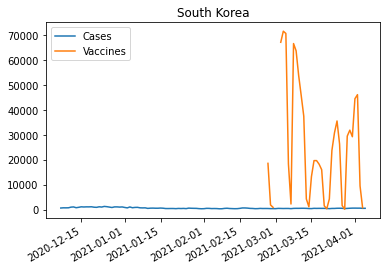

In South Korea, before the vaccine, 629.44 cases occured daily on average.
After the vaccine, 442.85 cases occured daily on average.



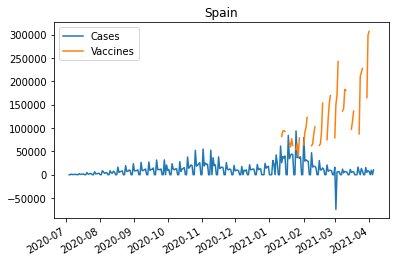

In Spain, before the vaccine, 9118.04 cases occured daily on average.
After the vaccine, 15033.26 cases occured daily on average.



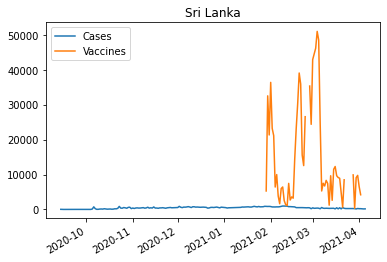

In Sri Lanka, before the vaccine, 422.5 cases occured daily on average.
After the vaccine, 483.84 cases occured daily on average.

too many
too many


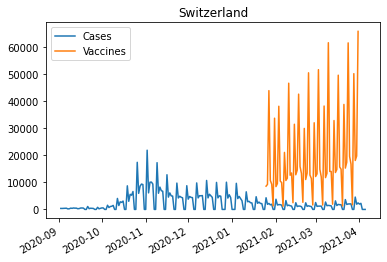

In Switzerland, before the vaccine, 3242.26 cases occured daily on average.
After the vaccine, 1334.21 cases occured daily on average.



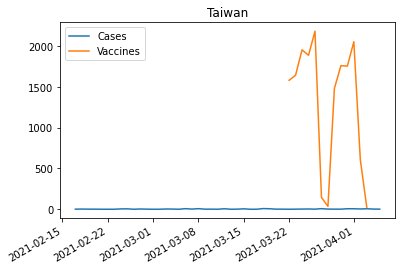

In Taiwan, before the vaccine, 2.12 cases occured daily on average.
After the vaccine, 2.69 cases occured daily on average.

too many
too many
too many


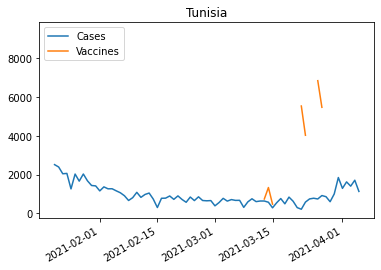

In Tunisia, before the vaccine, 1032.08 cases occured daily on average.
After the vaccine, 848.0 cases occured daily on average.



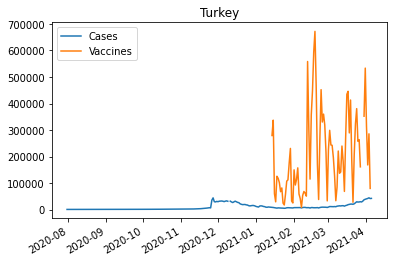

In Turkey, before the vaccine, 7837.39 cases occured daily on average.
After the vaccine, 14256.82 cases occured daily on average.

too many


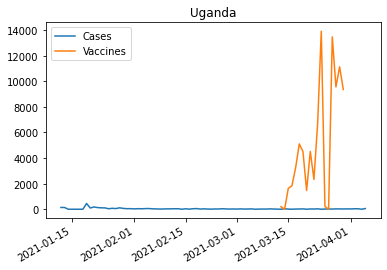

In Uganda, before the vaccine, 47.7 cases occured daily on average.
After the vaccine, 19.18 cases occured daily on average.



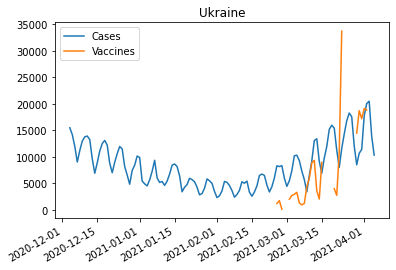

In Ukraine, before the vaccine, 6896.33 cases occured daily on average.
After the vaccine, 10937.95 cases occured daily on average.



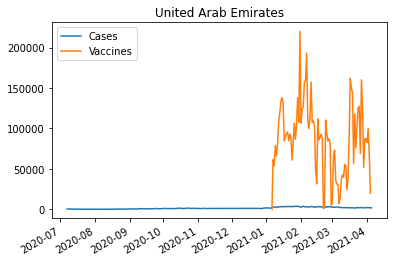

In United Arab Emirates, before the vaccine, 893.76 cases occured daily on average.
After the vaccine, 2828.75 cases occured daily on average.



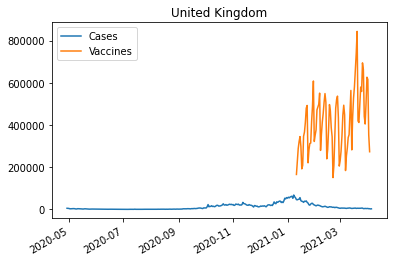

In United Kingdom, before the vaccine, 7314.01 cases occured daily on average.
After the vaccine, 22286.64 cases occured daily on average.



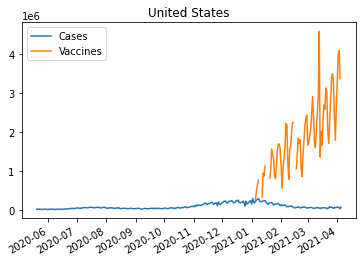

In United States, before the vaccine, 75830.14 cases occured daily on average.
After the vaccine, 121660.02 cases occured daily on average.



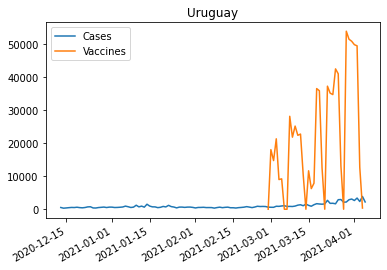

In Uruguay, before the vaccine, 623.18 cases occured daily on average.
After the vaccine, 1668.84 cases occured daily on average.

too many


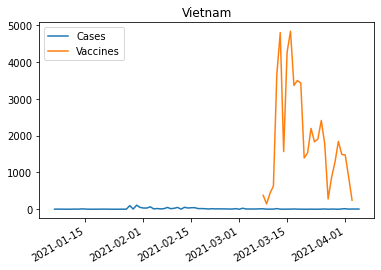

In Vietnam, before the vaccine, 16.62 cases occured daily on average.
After the vaccine, 4.53 cases occured daily on average.

too many


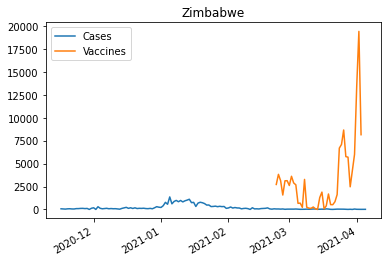

In Zimbabwe, before the vaccine, 282.91 cases occured daily on average.
After the vaccine, 32.15 cases occured daily on average.

25 countries improved after the distribution of vaccines.


In [ ]:
same_col = ['date', 'new_vaccinations', 'new_cases','country']
df3 = pd.DataFrame(columns=same_col)
temp_df = pd.DataFrame()
improved = 0
for country in countries:
  temp_df = temp_df.iloc[0:0]
  start_date = min(df.loc[df['country']==country].date)
  # print(start_date)
  # print(type(start_date))
  date_diff = (datetime.today() - start_date).days
  track_date = start_date + timedelta(days = -date_diff*2)
  temp_df = big_df.loc[big_df['country']==country]
  temp_df = temp_df.loc[temp_df['date'] >= track_date]
  temp_df.drop(temp_df.columns.difference(same_col),1,inplace=True)
  na_count = temp_df.new_vaccinations.isna().sum()
  b_avg = temp_df.loc[temp_df['date'] < start_date].new_cases.mean()
  a_avg = temp_df.loc[temp_df['date'] >= start_date].new_cases.mean()
  # print(f"{country}: {na_count}-{date_diff}={na_count-date_diff}")
  if na_count-date_diff > date_diff*0.9*2 or math.isnan(a_avg) == True:
    print('too many')
  else:
    # print("enough")
    X = temp_df.date
    y1 = temp_df.new_cases
    y2 = temp_df.new_vaccinations
    plt.plot(X, y1, label = 'Cases')
    plt.plot(X, y2, label = 'Vaccines')
    plt.gcf().autofmt_xdate()
    plt.title(country)
    plt.legend()
    plt.show() 
    print(f"In {country}, before the vaccine, {round(b_avg,2)} cases occured daily on average.")
    print(f"After the vaccine, {round(a_avg,2)} cases occured daily on average.\n")
    if b_avg > a_avg:
      improved+=1

print(f"{improved} countries improved after the distribution of vaccines.")


### Charts

#### Gantt chart

In [ ]:
gt = pd.DataFrame(columns=['Country','Start','Finish'])
gt = gt.iloc[0:0]
df_country = pd.DataFrame()
for country in df.country.unique():
    df_coutnry = df_country.iloc[0:0]
    df_country = df.loc[df['country']==country]
    min_date = min(df_country['date'])
    max_date = max(df_country['date'])
#     print(country, min_date, max_date)
    gt = gt.append({'Country':country,'Start':min_date,'Finish':max_date}, ignore_index = True)
    
# gt.head()
    
fig = px.timeline(gt, x_start="Start", x_end="Finish", y="Country", title = "Timeline of Country Vaccinations")
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

#### Line Charts

In [ ]:
fig = px.line(df, x="date", y="total_vaccinations", color='country', title = "Total Vaccinations by country")
fig.show()

In [ ]:
fig = px.line(df, x="date", y="total_vaccinations_per_hundred", color='country', title = "Total Vaccinations (per 100) by country")
fig.show()

In [ ]:
fig = px.line(df, x="date", y="people_fully_vaccinated_per_hundred", color='country', title = "People Fully Vaccinated by country (per 100)")
fig.show()

#### Choropleth Map



In [ ]:
uiso = df.iso_code.unique()

cm_df = pd.DataFrame(columns=df.columns)
ct_df = pd.DataFrame()
temp_df = pd.DataFrame()
max_date = 0


for u in uiso:
  temp_df = temp_df.iloc[0:0]
  ct_df = ct_df.iloc[0:0]
  ct_df = df.loc[df['iso_code'] == u] 
  max_date = ct_df.date.max()
  temp_df = ct_df.loc[ct_df['date'] == max_date]
  while math.isnan(temp_df.total_vaccinations_per_hundred):
    max_date = max_date + timedelta(days = -1)
    print('hello')
  temp_df = temp_df.loc[temp_df['date'] == max_date]
    
  cm_df = cm_df.append(temp_df)

In [ ]:
fig = px.choropleth(cm_df, locations = cm_df.country.unique(), locationmode= "country names", color = "total_vaccinations_per_hundred", color_continuous_scale='peach', range_color=[0,100], title="Total Vaccinations Per Hundred")
fig.show()

In [ ]:
usa = pd.read_csv('https://covid.ourworldindata.org/data/vaccinations/us_state_vaccinations.csv')
usa['date'] = pd.to_datetime(usa['date'])
state = usa.location.unique()
usa['state'] = usa['location'].apply(lambda x: us_state_abbrev[x])
# usa['state'] = [us_state_abbrev.get(x, None) for x in list(usa.location)]
# usa.head()

In [ ]:
cm2_df = pd.DataFrame()
st_df = pd.DataFrame()

for s in state:
  counter = 0
  temp_df = temp_df.iloc[0:0]
  st_df = st_df.iloc[0:0]
  st_df = usa.loc[usa['location'] == s] 
  max_date = st_df.date.max()
  temp_df = st_df.loc[st_df['date'] == max_date]
  if math.isnan(temp_df.total_vaccinations_per_hundred):
    pass
  cm2_df = cm2_df.append(temp_df)
# cm2_df.head()

In [ ]:
fig2 = px.choropleth(cm2_df, locations = usa.state.unique(), scope = 'usa', locationmode= "USA-states", 
                    color = "total_vaccinations_per_hundred", range_color=[0,100], title="Total Vaccinations Per Hundred")

fig2.show()

#### USA Time Series Analysis

In [ ]:
usa = df.loc[df['country']=='United States'].reset_index().set_index(keys='index')
start = min(usa['date'])
usa['days_since'] = (usa['date']-start).dt.days
usa.head()
usa_y = usa.total_vaccinations_per_hundred
israel = df.loc[df['country']=='Israel']
israel = israel.iloc[1:-1]
isr_y = israel.total_vaccinations_per_hundred

In [ ]:
fig = px.line(usa, x="date", y="total_vaccinations_per_hundred", title = "USA Total Vaccinations Per 100")
fig.show()

In [ ]:
usa2 = usa.rename(columns={'date': 'ds', 'total_vaccinations_per_hundred':'y'})
m = Prophet()
m.fit(usa2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)
# future.tail()

In [ ]:
predict = m.predict(future)
predict = predict.loc[predict['yhat_lower'] <= 100]
predict.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
178,2021-06-16,107.084156,96.836813,115.616115,96.979889,115.781807,-0.158336,-0.158336,-0.158336,-0.158336,-0.158336,-0.158336,0.0,0.0,0.0,106.925819
179,2021-06-17,107.888424,97.453393,116.599319,97.564936,116.833485,-0.150748,-0.150748,-0.150748,-0.150748,-0.150748,-0.150748,0.0,0.0,0.0,107.737676
180,2021-06-18,108.692692,98.143709,117.743998,98.189533,117.798609,-0.012263,-0.012263,-0.012263,-0.012263,-0.012263,-0.012263,0.0,0.0,0.0,108.680429
181,2021-06-19,109.496960,98.917147,118.903351,98.788186,118.740647,0.188658,0.188658,0.188658,0.188658,0.188658,0.188658,0.0,0.0,0.0,109.685618
182,2021-06-20,110.301228,99.466522,119.845364,99.392282,119.700834,0.210256,0.210256,0.210256,0.210256,0.210256,0.210256,0.0,0.0,0.0,110.511484


Text(0.5, 1.0, 'USA')

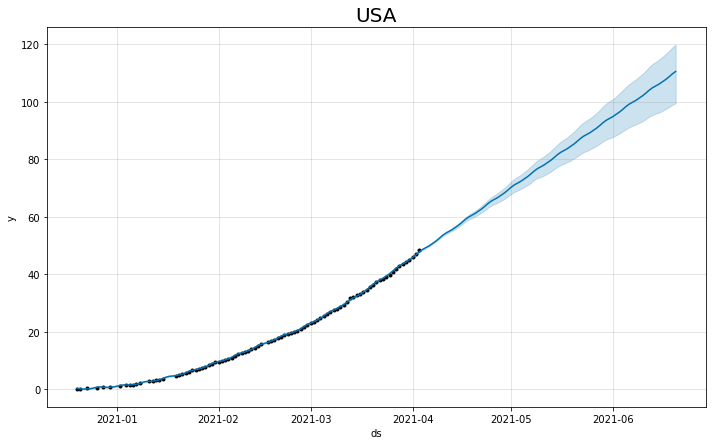

In [ ]:
fig = m.plot(predict);
ax = fig.gca()
ax.set_title('USA', size=20)

#### this might be a mistake

In [ ]:
# c_df = pd.DataFrame()
# for country in countries:
#   c_df = c_df.iloc[0:0]
#   c_df = df.loc[df['country']==country]
#   c_df = c_df.rename(columns={'date': 'ds', 'total_vaccinations_per_hundred':'y'})
#   m = Prophet()
#   future = future.iloc[0:0]
#   future = m.fit(c_df)
#   future = m.make_future_dataframe(periods=365)
#   predict = predict.iloc[0:0]
#   predict = m.predict(future)
#   predict = predict.loc[predict['yhat'] <= 100]
#   fig = m.plot(predict);
#   ax = fig.gca()
#   ax.set_title(country, size=20)



#### idek

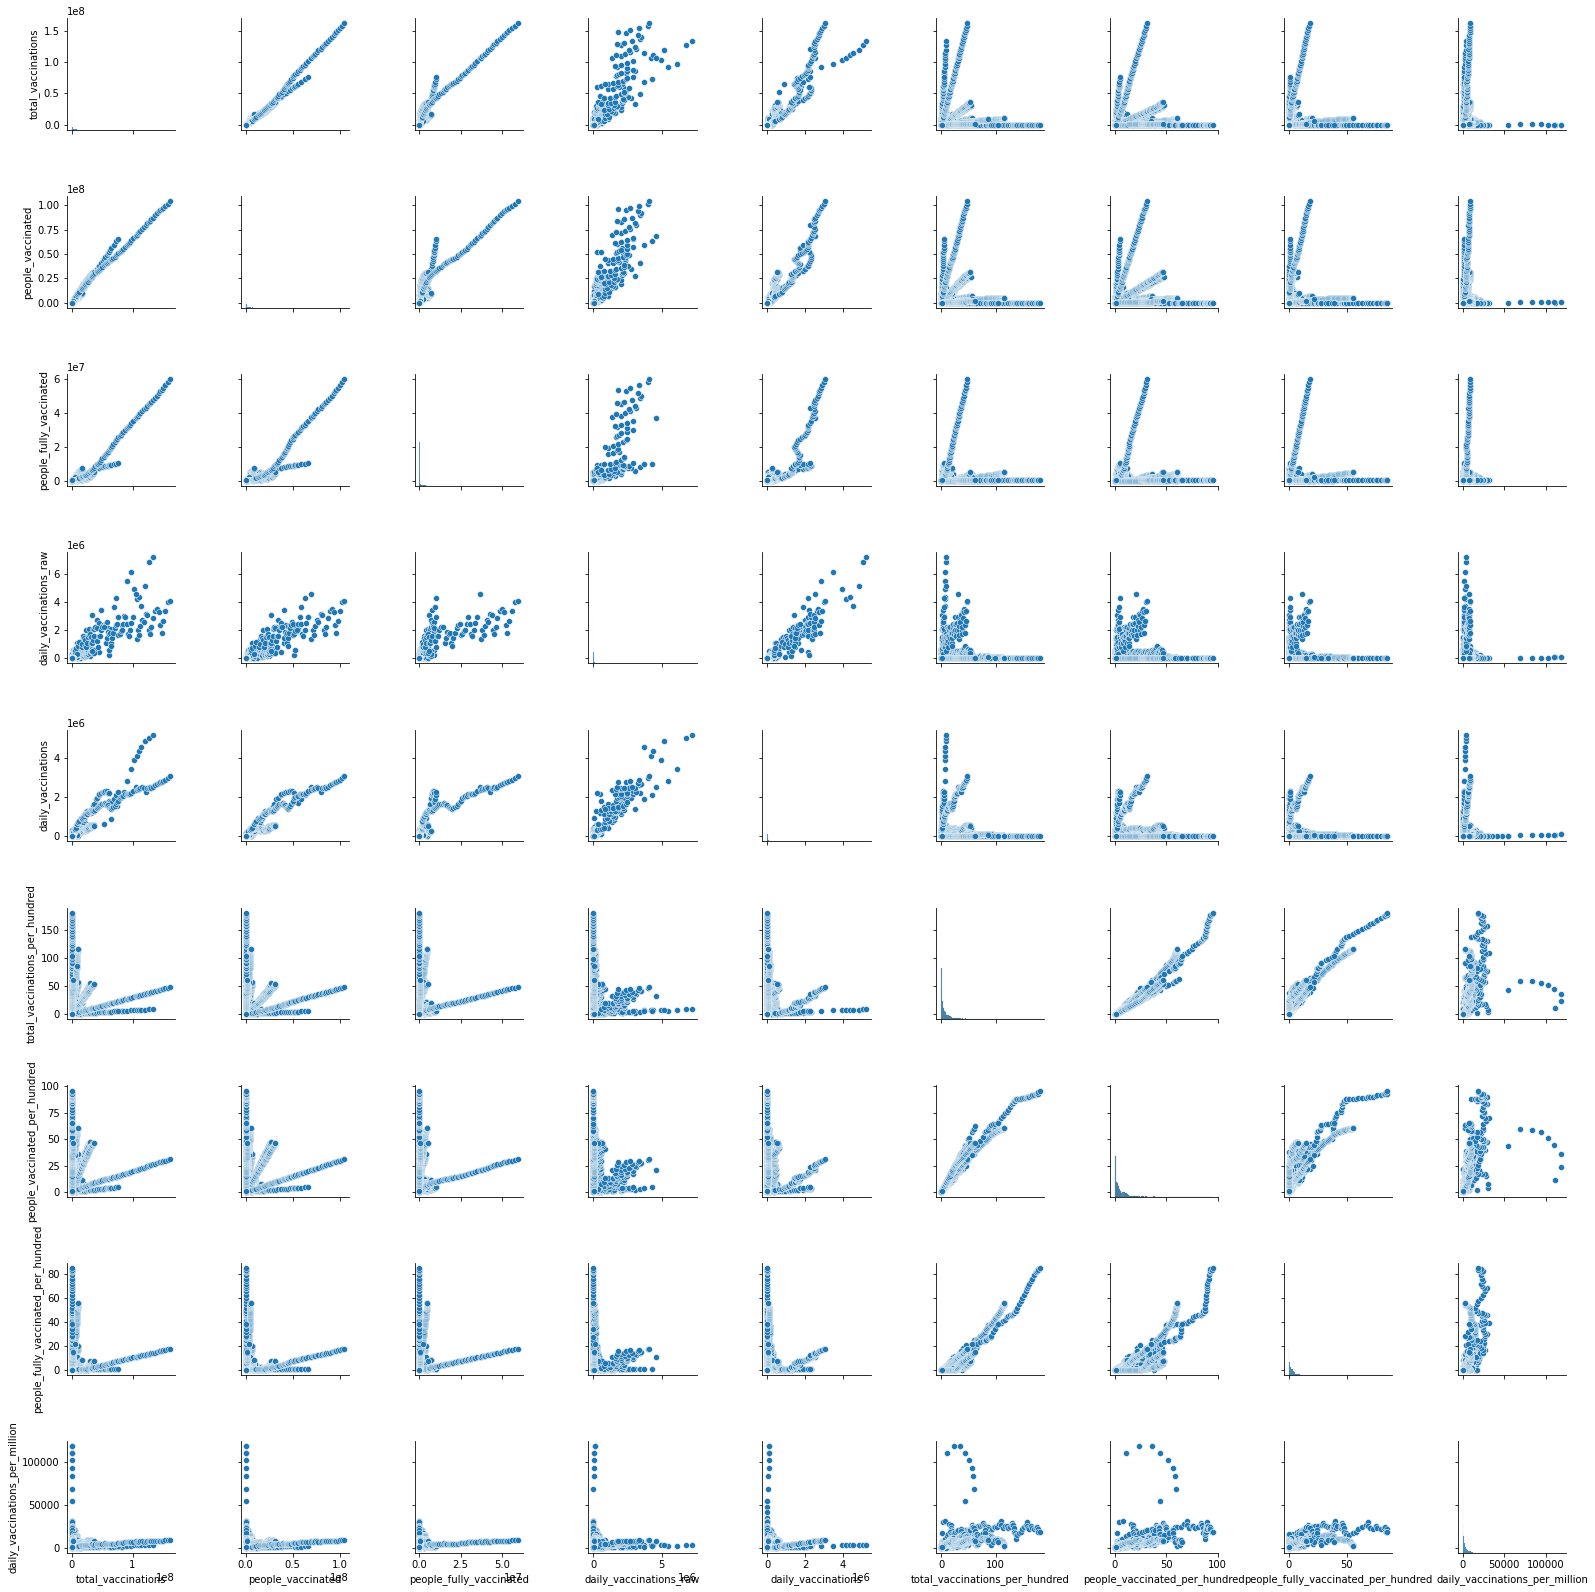

In [ ]:
sns.pairplot(df)